/home/langchenliu/anaconda3/envs/cst/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Compiling model...
'compile' took 0.000138 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [4.31e+01, 3.43e-03]    [4.88e+01, 3.43e-03]    [9.59e-01]    
1000      [3.24e-04, 2.53e-08]    [3.84e-04, 2.53e-08]    [7.39e-04]    
2000      [1.34e-04, 1.77e-06]    [1.70e-04, 1.77e-06]    [1.40e-03]    
3000      [2.60e-04, 5.88e-06]    [2.64e-04, 5.88e-06]    [2.40e-03]    
4000      [3.83e-04, 6.77e-05]    [3.50e-04, 6.77e-05]    [8.44e-03]    
5000      [9.36e-04, 1.37e-05]    [1.06e-03, 1.37e-05]    [6.94e-03]    
6000      [6.74e-04, 8.14e-05]    [6.73e-04, 8.14e-05]    [9.93e-03]    
7000      [2.77e-04, 4.26e-05]    [1.86e-04, 4.26e-05]    [6.53e-03]    
8000      [2.44e-03, 3.51e-04]    [2.23e-03, 3.51e-04]    [2.01e-02]    
9000      [1.86e-04, 3.34e-05]    [1.92e-04, 3.34e-05]    [6.28e-03]    
10000     [3.55e-05, 1.29e-06]    [5.01e-05, 1.29e-06]    [1.38e-03]    

Best model at step 10000:
  train loss: 3.68e-05
  test lo

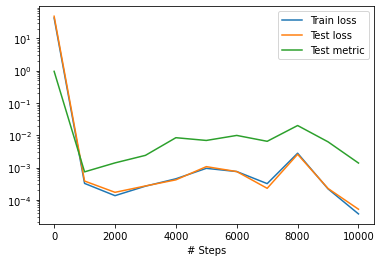

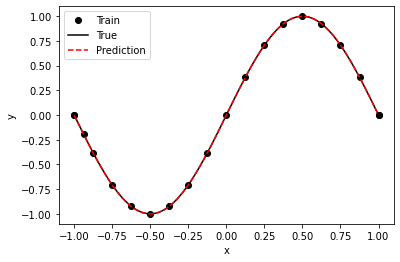

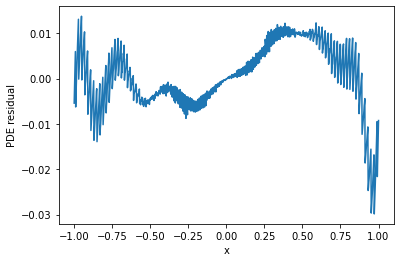

In [2]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from deepxde.backend import torch


def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return -dy_xx - np.pi ** 2 * torch.sin(np.pi * x)


def boundary(x, on_boundary):
    return on_boundary


def func(x):
    return np.sin(np.pi * x)


geom = dde.geometry.Interval(-1, 1)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

dde_model = dde.Model(data, net)
dde_model.compile("adam", lr=0.001, metrics=["l2 relative error"])

losshistory, train_state = dde_model.train(iterations=10000)


dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Optional: Restore the saved model with the smallest training loss
# model.restore(f"model/model-{train_state.best_step}.ckpt", verbose=1)
# Plot PDE residual
x = geom.uniform_points(1000, True)
y = dde_model.predict(x, operator=pde)
plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class PoissonDataset(Dataset):
    def __init__(self, x, y, device):
        # Reshape inputs to correct dimensions
        self.x = torch.FloatTensor(x).view(-1, 1).to(device)
        self.y = torch.FloatTensor(y).view(-1, 1).to(device)
        self.device = device
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)
# Load data
train_data = np.loadtxt('train.dat')
test_data = np.loadtxt('test.dat')

# Create datasets
train_dataset = PoissonDataset(train_data[:, 0], train_data[:, 1], device)
test_dataset = PoissonDataset(test_data[:, 0], test_data[:, 1], device)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=torch.Generator(device='cuda'),
    num_workers=0,  # Set to 0 when using CUDA
    pin_memory=False  # Set to False when data is already on GPU
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    generator=torch.Generator(device='cuda'),
    num_workers=0,  # Set to 0 when using CUDA
    pin_memory=False  # Set to False when data is already on GPU
)

# Verify dataloaders
print("Train loader batches:", len(train_loader))
print("Test loader batches:", len(test_loader))

# Example of iterating through a batch
for x_batch, y_batch in train_loader:
    print("Batch shapes:", x_batch.shape, y_batch.shape)
    print("Device:", x_batch.device)
    break

Device: cuda
Train loader batches: 1
Test loader batches: 4
Batch shapes: torch.Size([20, 1]) torch.Size([20, 1])
Device: cuda:0


In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from continuous_transformer.sobolev_loss import sobolev_loss

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

# L2 relative error metric
def l2_relative_error(pred, true):
    return torch.norm(pred - true, p=2) / torch.norm(true, p=2)

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
mse_loss = nn.MSELoss()
sob_loss = sobolev_loss(k=2, p=2, dim=1, bs=32)

# Training loop
num_epochs = 10000
train_losses = []
test_losses = []
l2_errors = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_l2_error = 0
    
    for x_batch, y_batch in train_loader:
        x_batch.requires_grad_(True)
        
        y_pred = model(x_batch)
        loss_mse = mse_loss(y_pred, y_batch)
        loss_sob = sob_loss.evaluate__loss(y_pred, y_batch, x_batch)
        loss = loss_mse + 0.01 * loss_sob
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_l2_error += l2_relative_error(y_pred, y_batch).item()
    
    # Validation
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            y_pred = model(x_test)
            test_loss += mse_loss(y_pred, y_test).item()
    
    train_losses.append(epoch_loss/len(train_loader))
    test_losses.append(test_loss/len(test_loader))
    l2_errors.append(epoch_l2_error/len(train_loader))
    
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_losses[-1]:.4f}')
        print(f'Test Loss: {test_losses[-1]:.4f}')
        print(f'L2 Relative Error: {l2_errors[-1]:.4f}\n')

Epoch [1000/10000]
Train Loss: 0.0914
Test Loss: 0.0005
L2 Relative Error: 0.0498

Epoch [2000/10000]
Train Loss: 0.1875
Test Loss: 0.0011
L2 Relative Error: 0.0635

Epoch [3000/10000]
Train Loss: 0.2169
Test Loss: 0.0023
L2 Relative Error: 0.0512

Epoch [4000/10000]
Train Loss: 0.1354
Test Loss: 0.0021
L2 Relative Error: 0.0479

Epoch [5000/10000]
Train Loss: 0.1398
Test Loss: 0.0026
L2 Relative Error: 0.0466

Epoch [6000/10000]
Train Loss: 0.1665
Test Loss: 0.0020
L2 Relative Error: 0.0438

Epoch [7000/10000]
Train Loss: 0.2046
Test Loss: 0.0020
L2 Relative Error: 0.0398

Epoch [8000/10000]
Train Loss: 0.2003
Test Loss: 0.0020
L2 Relative Error: 0.0389

Epoch [9000/10000]
Train Loss: 0.2010
Test Loss: 0.0023
L2 Relative Error: 0.0384

Epoch [10000/10000]
Train Loss: 0.2083
Test Loss: 0.0019
L2 Relative Error: 0.0375



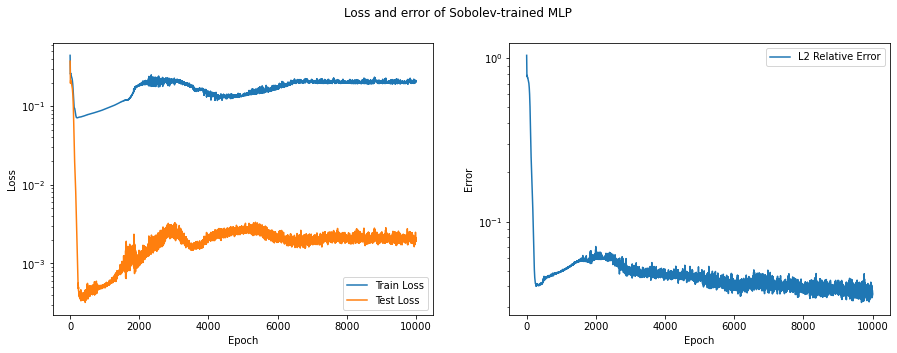

In [5]:
# Plot results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(l2_errors, label='L2 Relative Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.yscale('log')
plt.legend()
plt.suptitle('Loss and error of Sobolev-trained MLP')

plt.savefig('sobolev_loss.png')

L2 Relative Error (Sobolev-MLP): 4.769e-02
L2 Relative Error (PINN): 1.201e-03


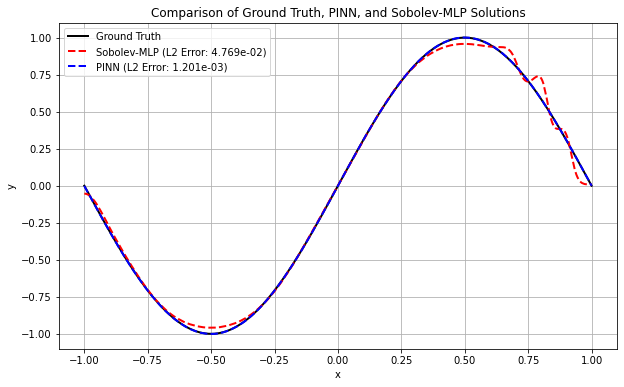

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Generate points for plotting
x_plot = np.linspace(-1, 1, 1000).reshape(-1, 1)
x_tensor = torch.FloatTensor(x_plot).to(device)

# Get predictions
model.eval()
with torch.no_grad():
    y_mlp = model(x_tensor).cpu().numpy()

# Get PINN predictions
y_pinn = dde_model.predict(x_plot)

# Calculate ground truth
y_true = np.sin(np.pi * x_plot)

# Calculate L2 relative errors
l2_error_mlp = np.linalg.norm(y_mlp - y_true) / np.linalg.norm(y_true)
l2_error_pinn = np.linalg.norm(y_pinn - y_true) / np.linalg.norm(y_true)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_plot, y_true, 'k-', label='Ground Truth', linewidth=2)
plt.plot(x_plot, y_mlp, 'r--', label=f'Sobolev-MLP (L2 Error: {l2_error_mlp:.3e})', linewidth=2)
plt.plot(x_plot, y_pinn, 'b--', label=f'PINN (L2 Error: {l2_error_pinn:.3e})', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparison of Ground Truth, PINN, and Sobolev-MLP Solutions')
plt.legend()
plt.grid(True)

plt.savefig('comparison.png')

print(f"L2 Relative Error (Sobolev-MLP): {l2_error_mlp:.3e}")
print(f"L2 Relative Error (PINN): {l2_error_pinn:.3e}")